# FLIR One Pro sensor calibration

It appears as if the raw RGB and FIR images do not line up exactly.
This notebook briefly explores ways to align the images.

In [225]:
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 11]
import numpy as np
import cv2
from pprint import pprint

In [226]:
root_path = "../../data/calibration"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)
    
scaling_factor = metadata["shape"]["vis"][0] / metadata["shape"]["thr"][0]
pprint(metadata)

{'candle_distances': {'left_middle': 415, 'middle_right': 380},
 'photos': {'flir_20191112T174218.jpg': {'adjusted': False,
                                         'distance': 1150,
                                         'points': {'thr': [[122, 202],
                                                            [322, 187],
                                                            [513, 187]],
                                                    'vis': [[362, 441],
                                                            [742, 424],
                                                            [1094, 422]]}},
            'flir_20191112T174252.jpg': {'adjusted': False,
                                         'distance': 1950,
                                         'points': {'thr': [[225, 218],
                                                            [346, 206],
                                                            [458, 207]],
                                            

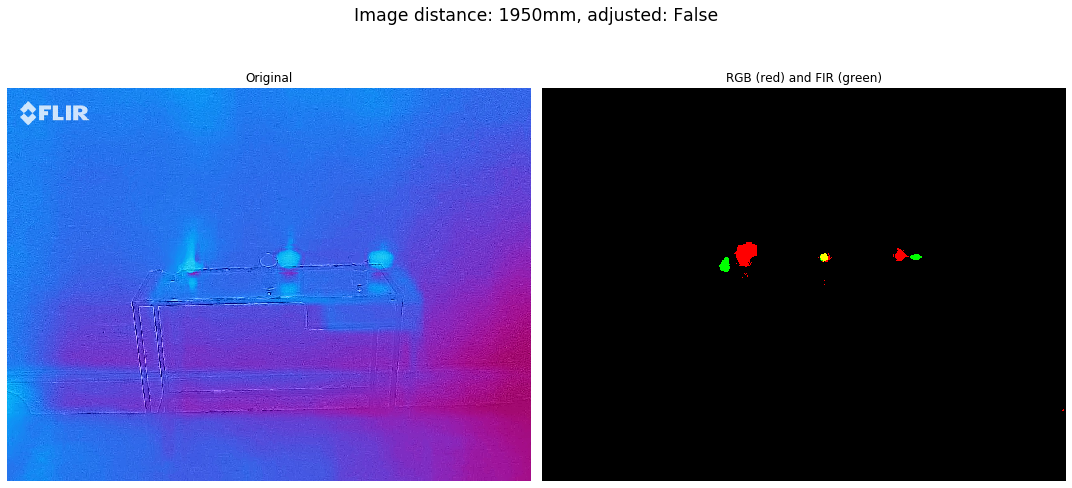

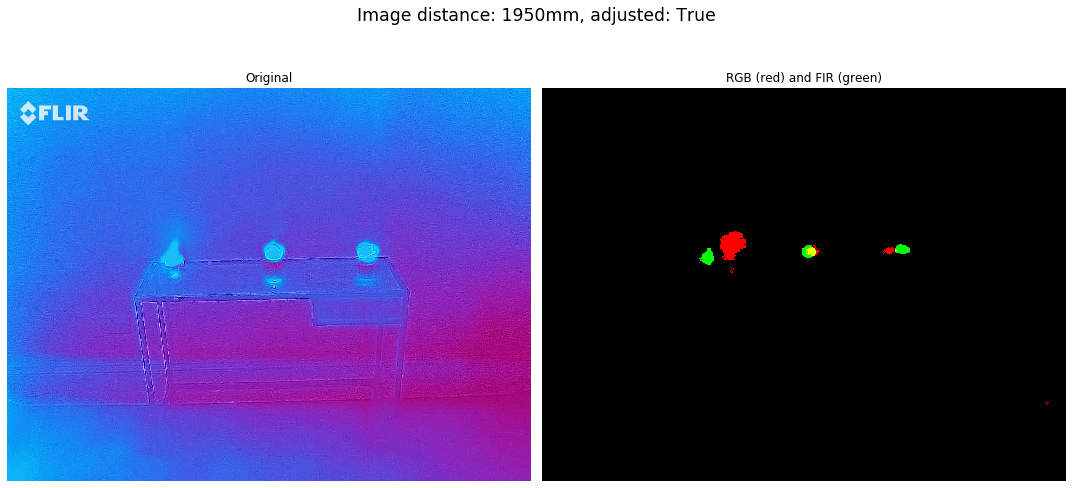

In [227]:
def load_images(name):
    original = cv2.imread(os.path.join(root_path, name)) / 255
    thermal = cv2.imread(os.path.join(root_path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(root_path, "extracted/visible", name)) / 255
    return original, thermal, visible

def display_images(name, metadata):
    orig, thr, vis = load_images(name)

    # Compress into single channel
    thr = np.mean(thr, 2)
    vis = np.mean(vis, 2)

    # Align shapes
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))

    # Threshold
    vis = np.where(vis > 0.91, 1, 0)
    thr = np.where(thr > 0.15, 1, 0)

    # Superimpose as red and green channel and plot
    sup = np.dstack([vis, thr, np.zeros(thr.shape)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(orig)
    ax1.set_title("Original")
    ax1.axis("off")
    ax2.imshow(sup)
    ax2.set_title("RGB (red) and FIR (green)")
    ax2.axis("off")
    
    distance = metadata["photos"][name]["distance"]
    adjusted = metadata["photos"][name]["adjusted"]
    fig.suptitle(f"Image distance: {distance}mm, adjusted: {adjusted}", y=0.85, size="xx-large")
    plt.tight_layout()


display_images(list(metadata["photos"].keys())[1], metadata)
display_images(list(metadata["photos"].keys())[6], metadata)

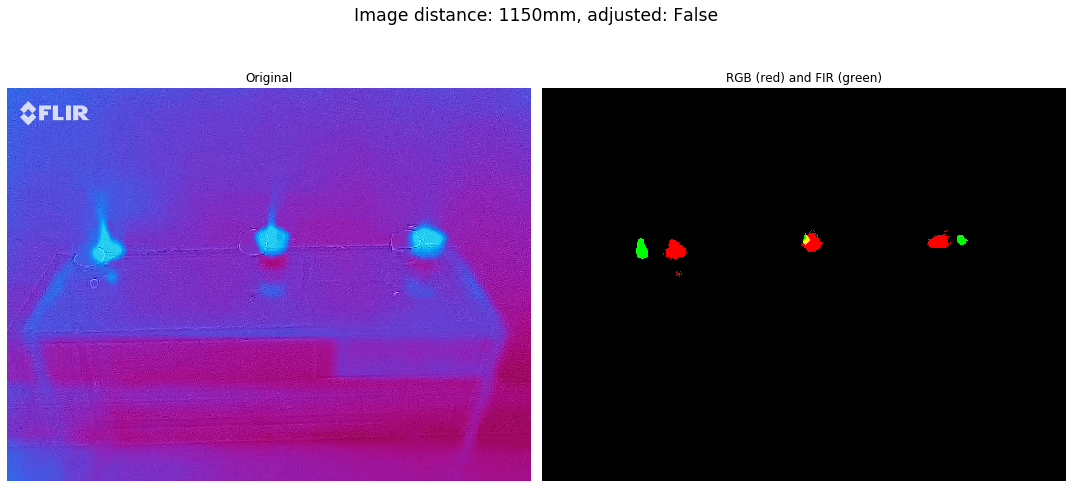

In [228]:
display_images(list(metadata["photos"].keys())[0], metadata)

In [229]:
def align(name, fac=0.09):
    orig, thr, vis = load_images(name)
    x, y, _ = vis.shape

    # Compress into single channel
    thr = np.mean(thr, 2)
    vis = np.mean(vis, 2)

    # Rescale images
    vis_r = vis[int(x*fac):int(x*(1-fac)), int(y*fac):int(y*(1-fac))]
    vis_r = cv2.resize(vis_r, (thr.shape[1], thr.shape[0]))
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))

    # Threshold
    vis_t = np.where(vis_r > 0.91, 1, 0)
    thr_t = np.where(thr > 0.15, 1, 0)

    # Superimpose
    sup_t = np.dstack([vis_t, thr_t, np.zeros(thr.shape)])
    sup = np.mean(np.dstack([vis, thr*5]), axis=2)
    sup_r = np.mean(np.dstack([vis_r, thr*5]), axis=2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    ax1.imshow(orig)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(sup_t)
    ax2.set_title("Rescaled RGB (red) and FIR (green)")
    ax2.axis("off")

    ax3.imshow(sup)
    ax3.set_title("Original superimposed")
    ax3.axis("off")

    ax4.imshow(sup_r)
    ax4.set_title("Rescaled superimposed")
    ax4.axis("off")

    fig.suptitle(f"Before and after rescaling", size="xx-large")
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

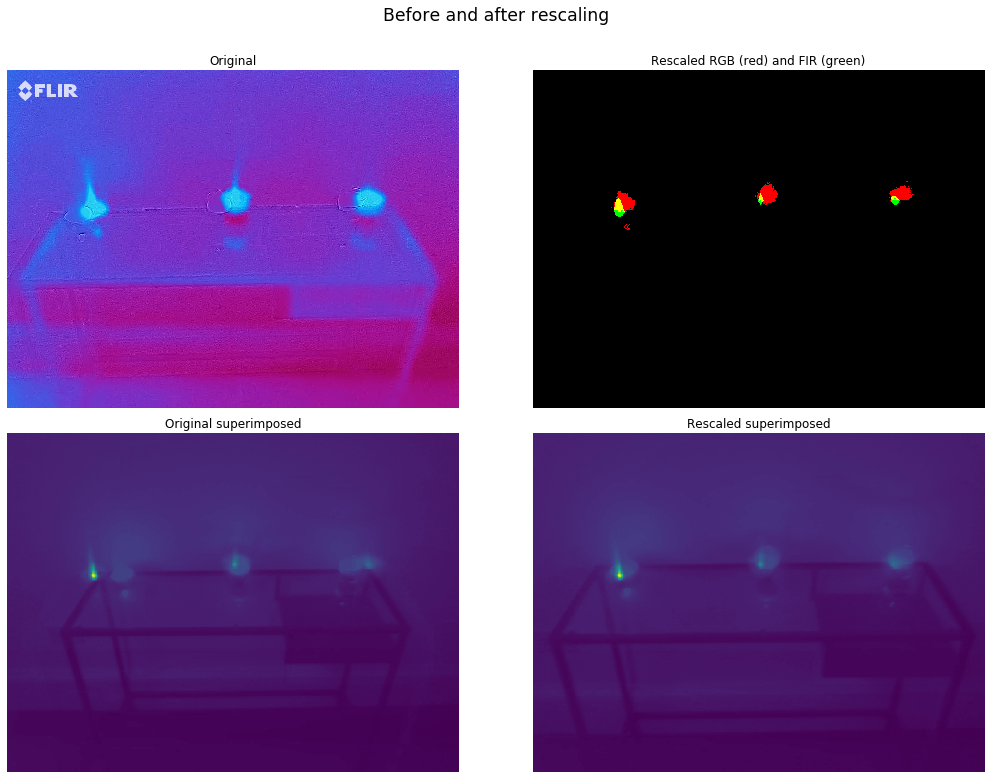

In [230]:
align(list(metadata["photos"].keys())[0], fac=0.09)

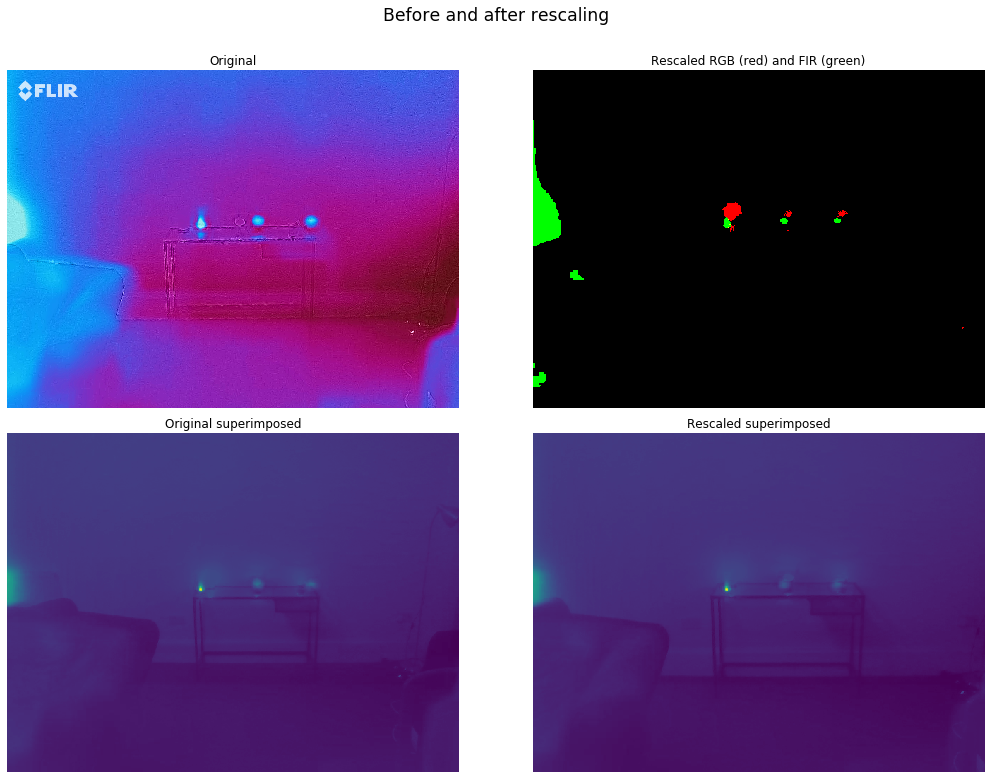

In [231]:
align(list(metadata["photos"].keys())[3], fac=0.09)

## Learn linear transformation

Use linear regression to estimate the parameters of linear transformation.

In [232]:
from sklearn.linear_model import LinearRegression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

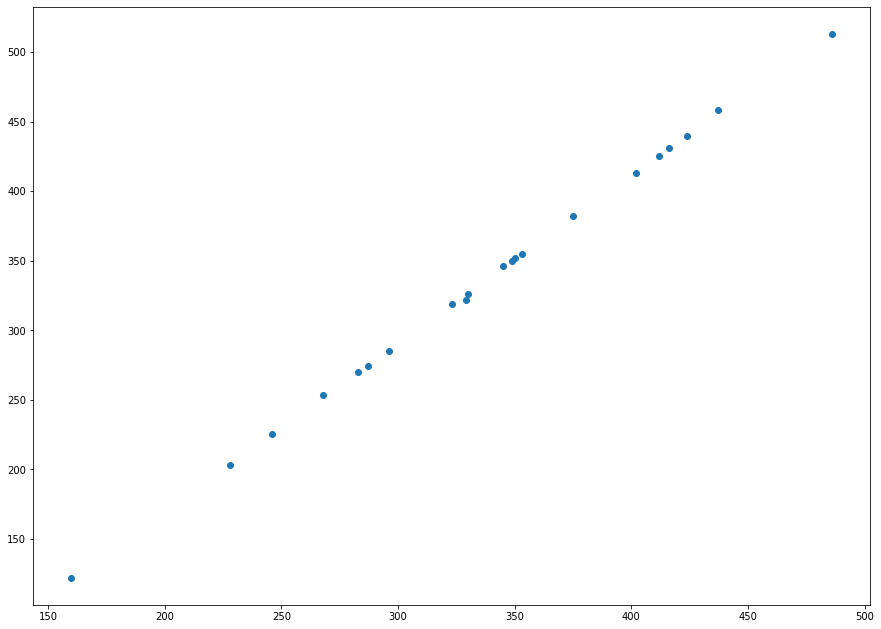

In [233]:
# Load reference points

X, y = [], []
for name, image in metadata["photos"].items():
    try:
        X.append(metadata["photos"][name]["points"]["vis"])
        y.append(metadata["photos"][name]["points"]["thr"])
    except:
        pass
    
X = np.vstack(X) // scaling_factor
y = np.vstack(y)

# Plot thermal x-value over visible x-value
# there appears to be a linear relationship
plt.scatter(X[:, 0], y[:, 0])

model = LinearRegression()
model.fit(X, y)

In [236]:
def show_transform(name, metadata, coef, intercept):
    """
        Displays transformation vectors as an overlay
        over the superimposed FIR and RGB image
    """
    orig, thr, vis = load_images(name)
    
    # Display superimposed image
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))
    sup = np.mean(np.dstack([vis, thr*5]), axis=2)
    plt.imshow(sup)

    # Test points
    X_test = np.array([[100, 100], [550, 100], [100, 400], [550, 400]])
    X_test = np.vstack([X_test, np.array(metadata["photos"][name]["points"]["vis"]) / scaling_factor])

    # Arrows
    y_pred = model.predict(X_test)
    for i in range(X_test.shape[0]):
        plt.annotate("", xy=X_test[i] @ coef.T + intercept, xytext=X_test[i], arrowprops=dict(arrowstyle="->", color="white", linewidth=3))

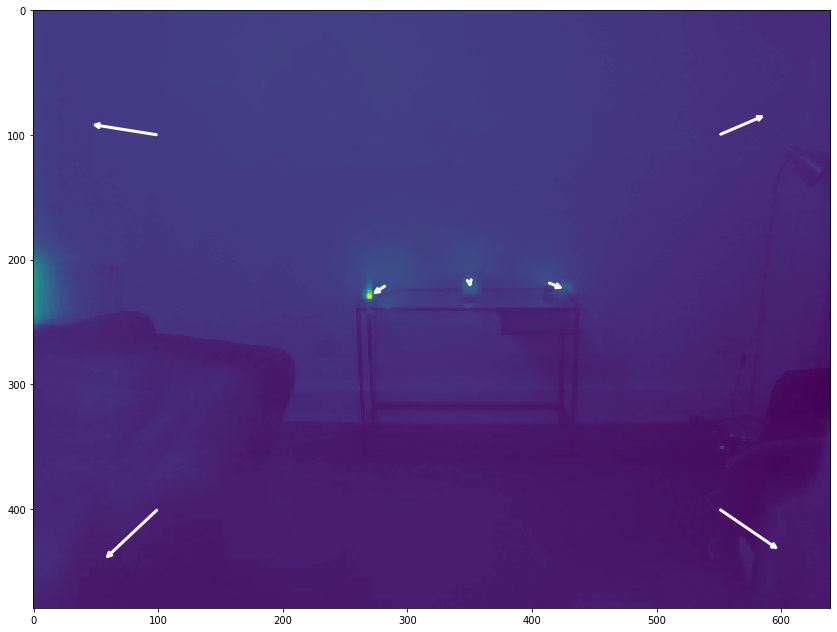

In [237]:
show_transform("flir_20191112T174307.jpg", metadata, model.coef_, model.intercept_)

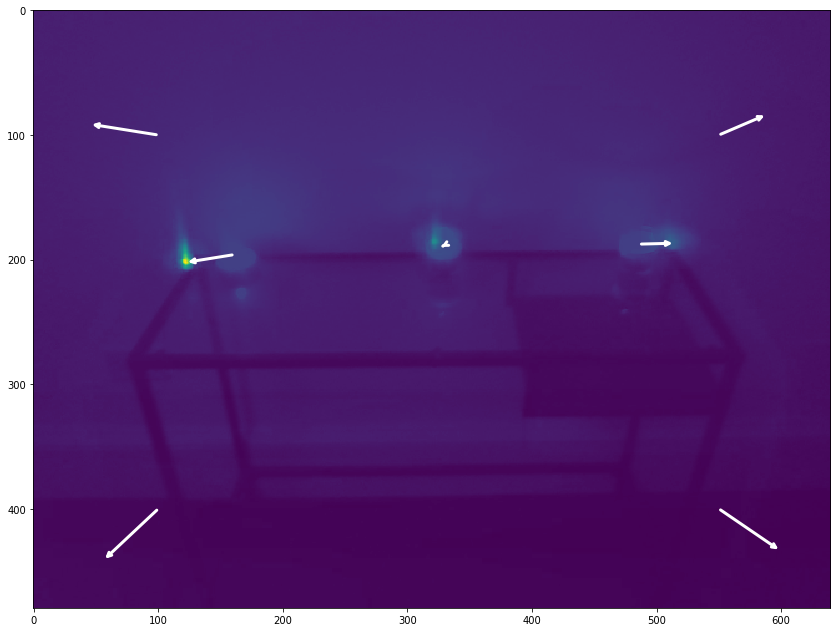

In [238]:
show_transform("flir_20191112T174218.jpg", metadata, model.coef_, model.intercept_)